# Steric optimization for the North Sea

In [1]:
import sys
sys.path.append('../code')
import importlib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import SeaLevelContrib as slc

import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('retina')

import statsmodels.api as sm
lowess = sm.nonparametric.lowess

In [2]:
importlib.reload(slc)

<module 'SeaLevelContrib' from '/Users/dewilebars/Projects/SLBudget/notebooks/../code/SeaLevelContrib.py'>

In [3]:
data_path = '../outputs/'

In [4]:
#b_df = pd.read_csv(f'{data_path}slbudget_2021_12_06_NS_Fred16_1950_2020_ERA5StericIAP_500m.csv')
b_df = pd.read_csv(f'{data_path}slbudget_2022_11_22_NL_region_altimetry_1993_2021_ERA5_StericIAP_2000m.csv')

b_df = b_df.set_index('time')

In [5]:
b_df

,Total,LocSteric,GloSteric,GIA,Glaciers,Antarctica,Greenland,TWS,Nodal,Wind,Pressure,Obs
time,,,,,,,,,,,,
1993,0.000000,0.000000,0.000000,0.0,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.392398
1994,-0.239490,-0.467188,0.093743,0.0,0.060,0.035000,0.000000,0.130000,-0.180338,1.564597,-1.475304,-0.695512
1995,3.299817,3.933431,-0.002695,0.0,0.120,0.055000,0.005000,0.200000,-0.329240,0.136448,-0.818128,2.090393
1996,-2.662205,2.598571,0.302123,0.0,0.145,0.065000,0.000000,-0.060000,-0.429893,-5.114104,-0.168903,-5.479014
1997,1.443105,2.654719,0.333315,0.0,0.205,0.080000,0.005000,-0.070000,-0.470932,-1.681658,0.387662,1.176818
1998,4.088186,2.937055,0.356420,0.0,0.260,0.095000,0.005000,0.255000,-0.447724,1.969267,-1.341832,4.263695
1999,4.579030,4.297327,0.563422,0.0,0.295,0.120000,0.005000,0.180000,-0.362889,1.303556,-1.822386,3.473304
2000,4.643317,5.335747,0.520010,0.0,0.320,0.145000,0.010000,-0.030000,-0.226006,0.705609,-2.137043,1.106225
2001,4.659903,5.413130,0.809437,0.0,0.350,0.160000,0.015000,0.200000,-0.052530,-1.281051,-0.954083,4.192586


In [6]:
st = slc.StericSL('EN4_22', 'EBB', 0, 2000, 0)
st = st.loc[1950:] - st.loc[1950]
st

,Steric
time,
1950,0.000000
1951,-5.440319
1952,-6.328735
1953,-0.298883
1954,-3.932748
...,...
2017,-0.949332
2018,-2.310930
2019,-1.101408


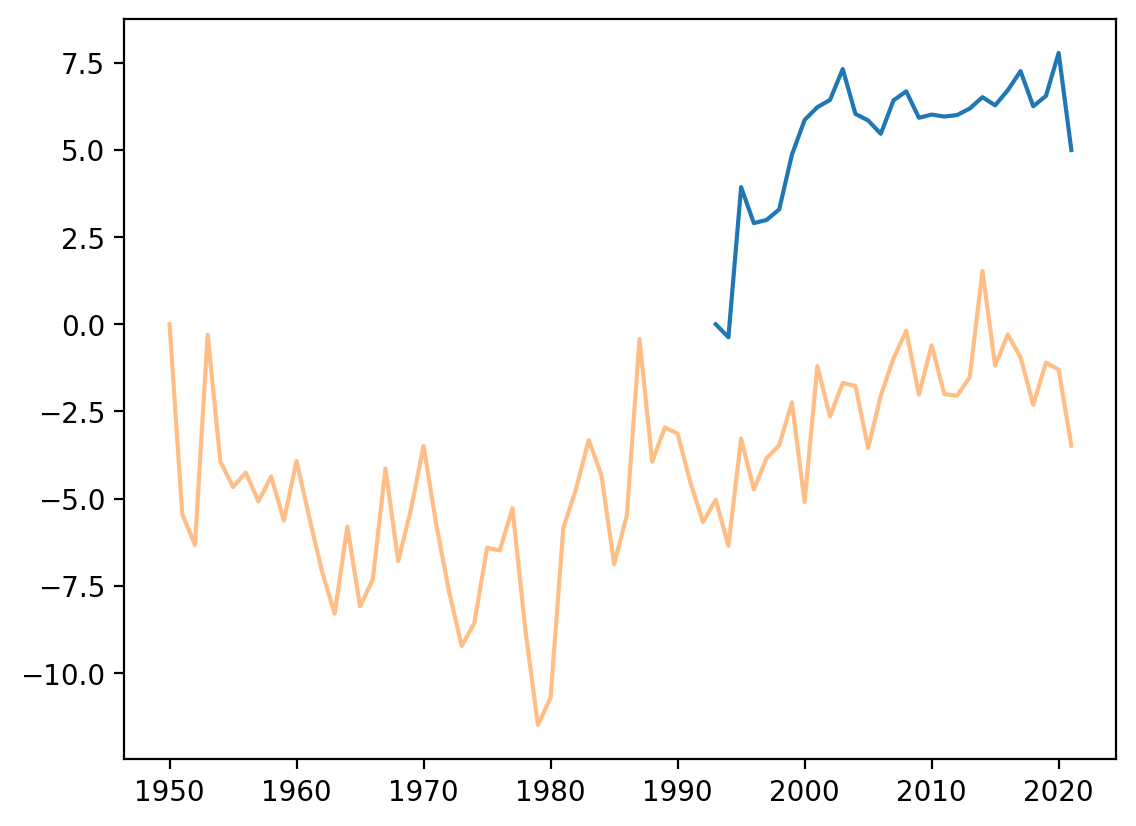

In [7]:
plt.plot(b_df['LocSteric']+b_df['GloSteric'])
plt.plot(st, alpha=0.5)

## One layer model

In [8]:
depth_range = np.arange(100,5100,200)
product = 'EN4_22' # IAP, EN4

try:
    del(full_error_df)
except:
    print('full_error_df not yet defined')
    
loc_b_df = b_df.copy()

for reg in ['ENS', 'EBB', 'NWS']:
    for window in range(1,13,2):
        print(f'Starting region {reg} with window {window}')
        
        error_df = pd.DataFrame(columns=['Depth', f'RMSE_{reg}_{window}', 
                                         f'AE_{reg}_{window}',
                                         f'linear_{reg}_{window}'])
        error_df['Depth'] = depth_range
        error_df = error_df.set_index('Depth')

        for d in depth_range:
            st = slc.StericSL(product, reg, 0, d, window)
            st = st.loc[b_df.index[0]:] - st.loc[b_df.index[0]]
            
            nt = loc_b_df.loc[:,'GIA':'Pressure'].sum(axis=1) + st.Steric
            diff_df = loc_b_df.Obs - nt
            diff_df = diff_df - diff_df.mean()
            RMSE = np.sqrt( (diff_df**2).sum() ) / len(diff_df)
            AE = np.abs(diff_df).sum() / len(diff_df)
            lin_trend = np.polyfit(diff_df.index, 
                                   diff_df * 10, 1)[0]  # Convert from cm to mm
            error_df.loc[d] = [RMSE, AE, lin_trend]

        if 'full_error_df' in locals():
            full_error_df = full_error_df.join(error_df)
        else:
            full_error_df = error_df.copy()

full_error_df not yet defined
Starting region ENS with window 1
Starting region ENS with window 3
Starting region ENS with window 5
Starting region ENS with window 7
Starting region ENS with window 9
Starting region ENS with window 11
Starting region EBB with window 1
Starting region EBB with window 3
Starting region EBB with window 5
Starting region EBB with window 7
Starting region EBB with window 9
Starting region EBB with window 11
Starting region NWS with window 1
Starting region NWS with window 3
Starting region NWS with window 5
Starting region NWS with window 7
Starting region NWS with window 9
Starting region NWS with window 11


In [9]:
full_error_df.to_csv('../outputs/steric_optimization_EN4_1layer.csv')

In [10]:
error_IAP_df = pd.read_csv('../outputs/steric_optimization_IAP_1layer.csv')
error_IAP_df.set_index('Depth', inplace=True)
error_IAP_df

,RMSE_ENS_1,AE_ENS_1,linear_ENS_1,RMSE_ENS_3,AE_ENS_3,linear_ENS_3,RMSE_ENS_5,AE_ENS_5,linear_ENS_5,RMSE_ENS_7,...,linear_NWS_5,RMSE_NWS_7,AE_NWS_7,linear_NWS_7,RMSE_NWS_9,AE_NWS_9,linear_NWS_9,RMSE_NWS_11,AE_NWS_11,linear_NWS_11
Depth,,,,,,,,,,,,,,,,,,,,,
100,0.405657,1.684425,2.015956,0.405657,1.684425,2.015956,0.416125,1.725139,2.013149,0.419153,...,1.837468,0.402007,1.657498,1.851552,0.405750,1.652805,1.857232,0.408712,1.650674,1.860316
200,0.362538,1.528350,1.751956,0.362538,1.528350,1.751956,0.384762,1.624192,1.818781,0.386473,...,1.432516,0.357870,1.532989,1.456161,0.361439,1.516028,1.460364,0.365256,1.506658,1.464303
300,0.332013,1.421992,1.513040,0.332013,1.421992,1.513040,0.358408,1.535149,1.593492,0.358376,...,1.235586,0.344563,1.491847,1.257398,0.346036,1.472338,1.265037,0.348874,1.461309,1.266503
400,0.312253,1.339445,1.311881,0.312253,1.339445,1.311881,0.338215,1.473388,1.373044,0.341582,...,1.193532,0.346751,1.497865,1.222068,0.346979,1.477519,1.232100,0.349176,1.463368,1.231449
500,0.303050,1.308141,1.156865,0.303050,1.308141,1.156865,0.329227,1.462779,1.223690,0.332018,...,1.188608,0.350375,1.506933,1.216213,0.350397,1.486190,1.227914,0.351956,1.473606,1.229792
600,0.296025,1.290758,1.029855,0.296025,1.290758,1.029855,0.325076,1.459367,1.130376,0.325494,...,1.141573,0.345342,1.486984,1.168800,0.345597,1.467205,1.181196,0.348111,1.458305,1.186666
700,0.292904,1.287914,0.968328,0.292904,1.287914,0.968328,0.318337,1.446423,1.043107,0.322445,...,1.067190,0.338141,1.463273,1.094883,0.338690,1.441078,1.109279,0.341885,1.433757,1.116461
800,0.291625,1.283093,0.944959,0.291625,1.283093,0.944959,0.314089,1.434259,0.994473,0.319442,...,1.019514,0.334843,1.448726,1.048041,0.335004,1.425338,1.059333,0.338376,1.419481,1.066542
900,0.290472,1.273118,0.927174,0.290472,1.273118,0.927174,0.312517,1.428013,0.978944,0.319273,...,0.941275,0.330766,1.427123,0.972278,0.330465,1.401926,0.978074,0.333963,1.400570,0.983856


In [11]:
error_EN4_df = pd.read_csv('../outputs/steric_optimization_EN4_1layer.csv')
error_EN4_df.set_index('Depth', inplace=True)
error_EN4_df

,RMSE_ENS_1,AE_ENS_1,linear_ENS_1,RMSE_ENS_3,AE_ENS_3,linear_ENS_3,RMSE_ENS_5,AE_ENS_5,linear_ENS_5,RMSE_ENS_7,...,linear_NWS_5,RMSE_NWS_7,AE_NWS_7,linear_NWS_7,RMSE_NWS_9,AE_NWS_9,linear_NWS_9,RMSE_NWS_11,AE_NWS_11,linear_NWS_11
Depth,,,,,,,,,,,,,,,,,,,,,
100,0.409476,1.706345,2.066997,0.409476,1.706345,2.066997,0.421992,1.765680,2.098392,0.422975,...,1.922768,0.404602,1.694908,1.929775,0.407788,1.697095,1.936431,0.410969,1.699097,1.941678
300,0.344738,1.466433,1.691008,0.344738,1.466433,1.691008,0.368355,1.584593,1.782012,0.373800,...,1.457666,0.348035,1.528815,1.474320,0.348107,1.511099,1.475384,0.350587,1.502145,1.481305
500,0.313407,1.369068,1.415790,0.313407,1.369068,1.415790,0.344878,1.526266,1.539890,0.355314,...,1.339332,0.343646,1.534625,1.375690,0.341340,1.504860,1.392002,0.341752,1.484192,1.401326
700,0.295765,1.311579,1.136426,0.295765,1.311579,1.136426,0.329599,1.486293,1.254844,0.335905,...,1.278920,0.340673,1.523643,1.319388,0.335921,1.487304,1.325743,0.337050,1.470135,1.344058
900,0.288474,1.259376,1.062239,0.288474,1.259376,1.062239,0.324102,1.451876,1.169025,0.327777,...,1.195924,0.332161,1.495961,1.229644,0.328432,1.462598,1.244128,0.329918,1.445754,1.263586
1100,0.289552,1.258839,1.004444,0.289552,1.258839,1.004444,0.321611,1.456120,1.094582,0.325590,...,1.004758,0.317033,1.452112,1.037050,0.312933,1.418002,1.055326,0.314121,1.395295,1.072438
1300,0.297126,1.290530,1.005138,0.297126,1.290530,1.005138,0.326518,1.457905,1.110724,0.334579,...,0.885750,0.307205,1.421023,0.922977,0.302555,1.385153,0.935789,0.303786,1.363950,0.950709
1500,0.300764,1.297855,0.977150,0.300764,1.297855,0.977150,0.334007,1.482002,1.110788,0.341481,...,0.746386,0.296268,1.381045,0.776233,0.292320,1.351520,0.794411,0.293321,1.331284,0.807206
1700,0.296601,1.283918,0.889310,0.296601,1.283918,0.889310,0.329913,1.465284,1.038323,0.335265,...,0.610847,0.287844,1.350886,0.640603,0.283068,1.318298,0.655052,0.284283,1.298509,0.673447


## Check results 1 layer

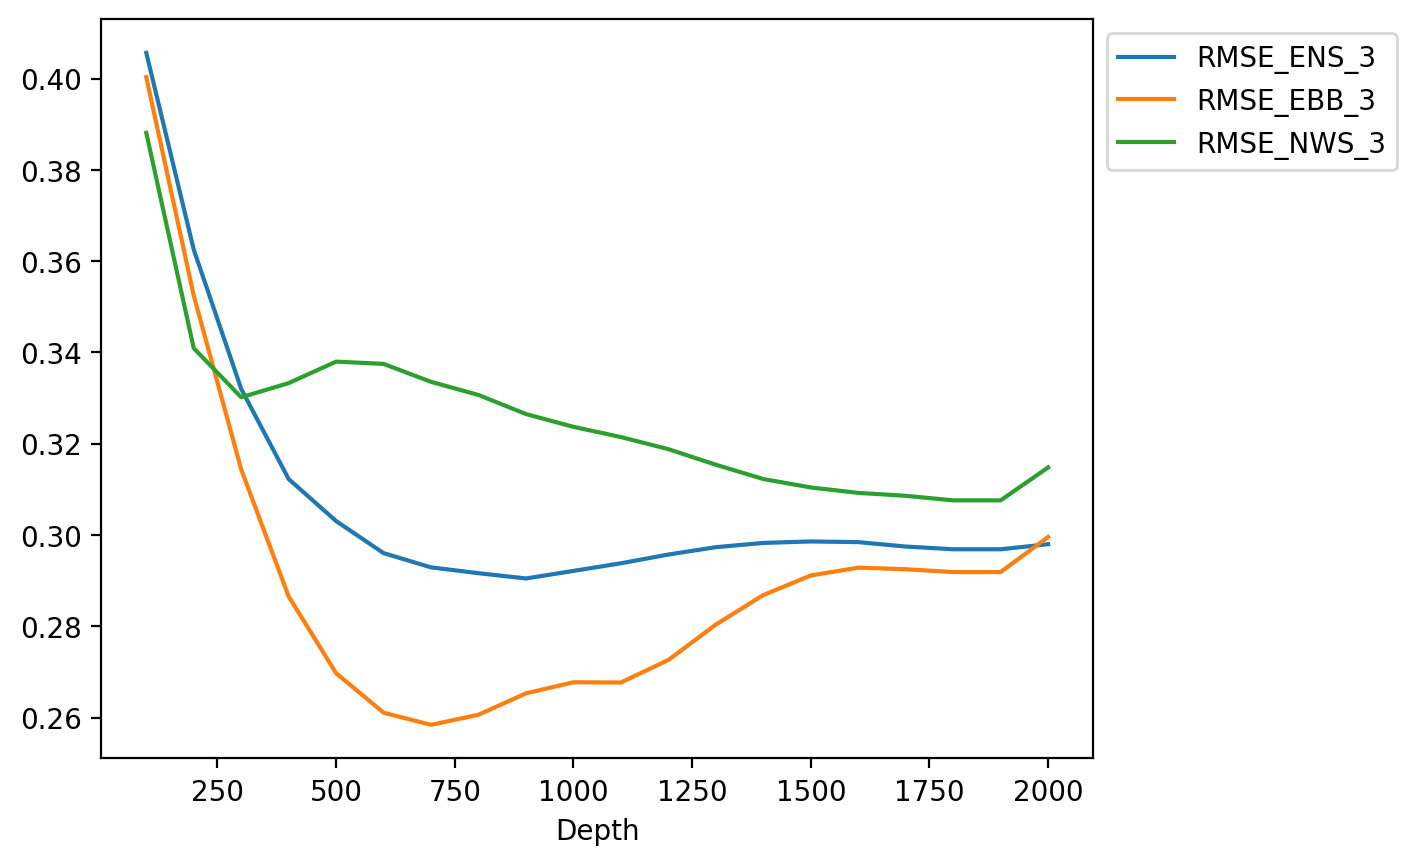

In [12]:
error_IAP_df.filter(like='RMSE').filter(like='3').plot()
plt.legend(bbox_to_anchor=(1,1), loc="upper left")

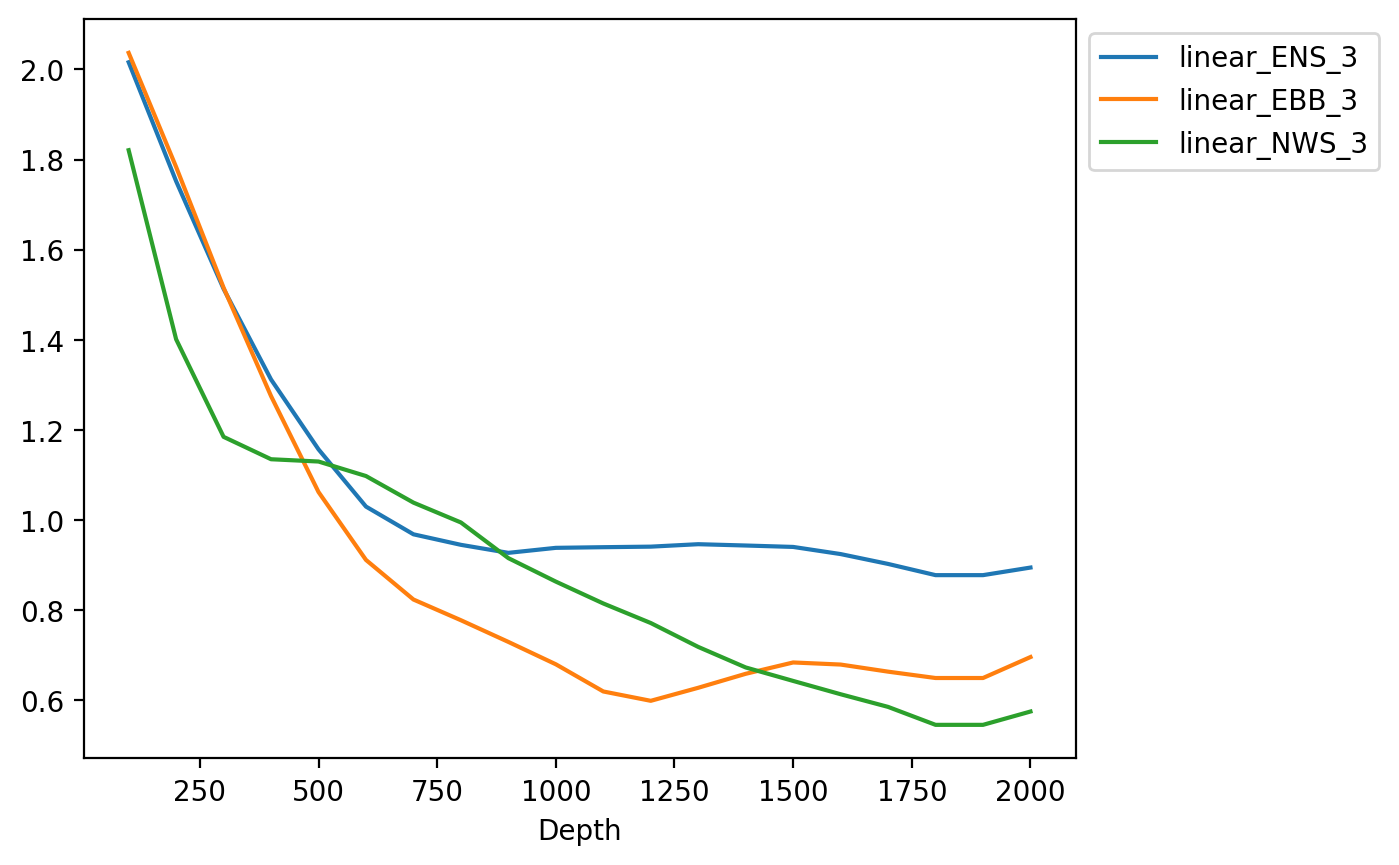

In [13]:
error_IAP_df.filter(like='linear').filter(like='3').plot()
plt.legend(bbox_to_anchor=(1,1), loc="upper left")

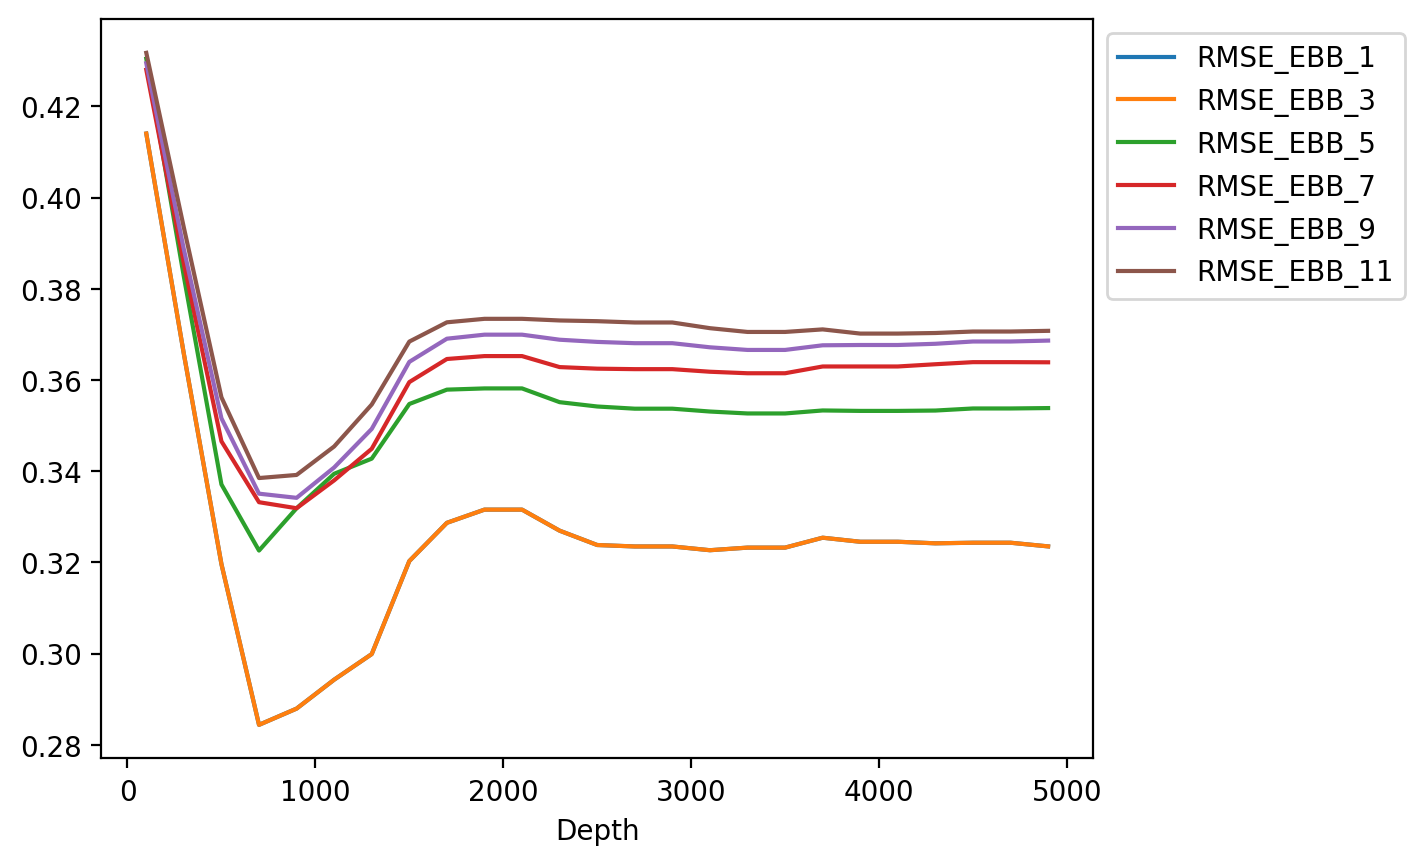

In [14]:
error_EN4_df.filter(like='RMSE').filter(like='EBB').plot()
plt.legend(bbox_to_anchor=(1,1), loc="upper left")

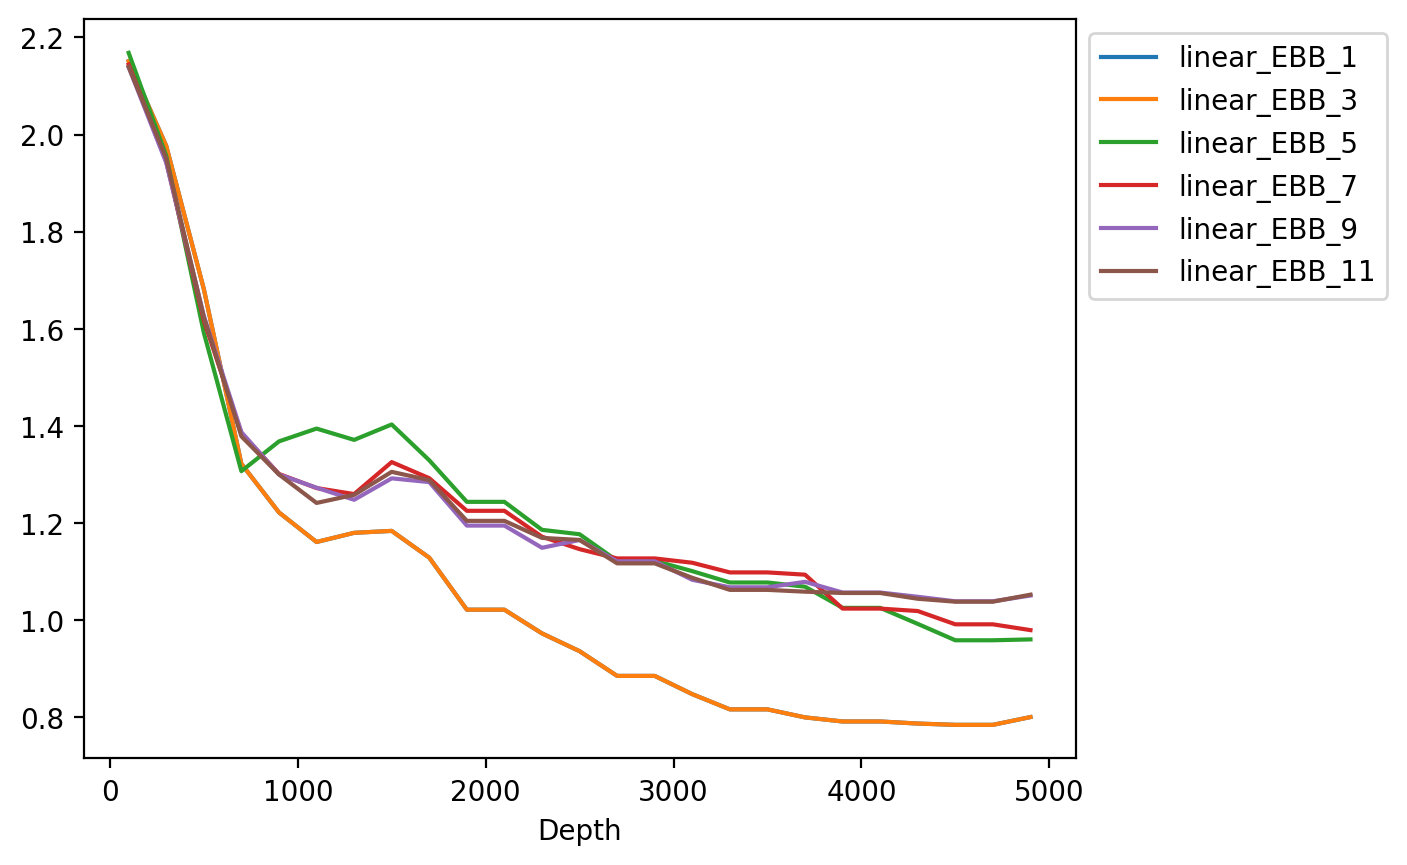

In [15]:
error_EN4_df.filter(like='linear').filter(like='EBB').plot()
plt.legend(bbox_to_anchor=(1,1), loc="upper left")

## Two layer model

In [40]:
windows = [1, 13]

depth_range = np.arange(50,2050,50)

error_df = pd.DataFrame(columns=['Depth', 'RMSE', 'AE', 'linear'])
error_df['Depth'] = depth_range
error_df = error_df.set_index('Depth')

for d in depth_range:
    print(d)
    
    st1 = slc.StericSL('EN4_22', 'EBB', 0, d, windows[0])
    
    st2 = slc.StericSL('EN4_22', 'NWS', d, 4000, windows[1])
    
    st = st1+st2
    st = st.loc[b_df.index[0]:] - st.loc[b_df.index[0]]

    nt = b_df.loc[:,'GIA':'Pressure'].sum(axis=1) + st.Steric
    diff_df = b_df.Obs - nt
    diff_df = diff_df - diff_df.mean()
    RMSE = np.sqrt( (diff_df**2).sum() ) / len(diff_df)
    AE = np.abs(diff_df).sum() / len(diff_df)    
    lin_trend = np.polyfit(diff_df.index, 
                       diff_df * 10, 1)[0]  # Convert from cm to mm
    
    error_df.loc[d] = [RMSE, AE, lin_trend]
   

50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000


## Check results 2 layer model

<AxesSubplot: xlabel='Depth'>

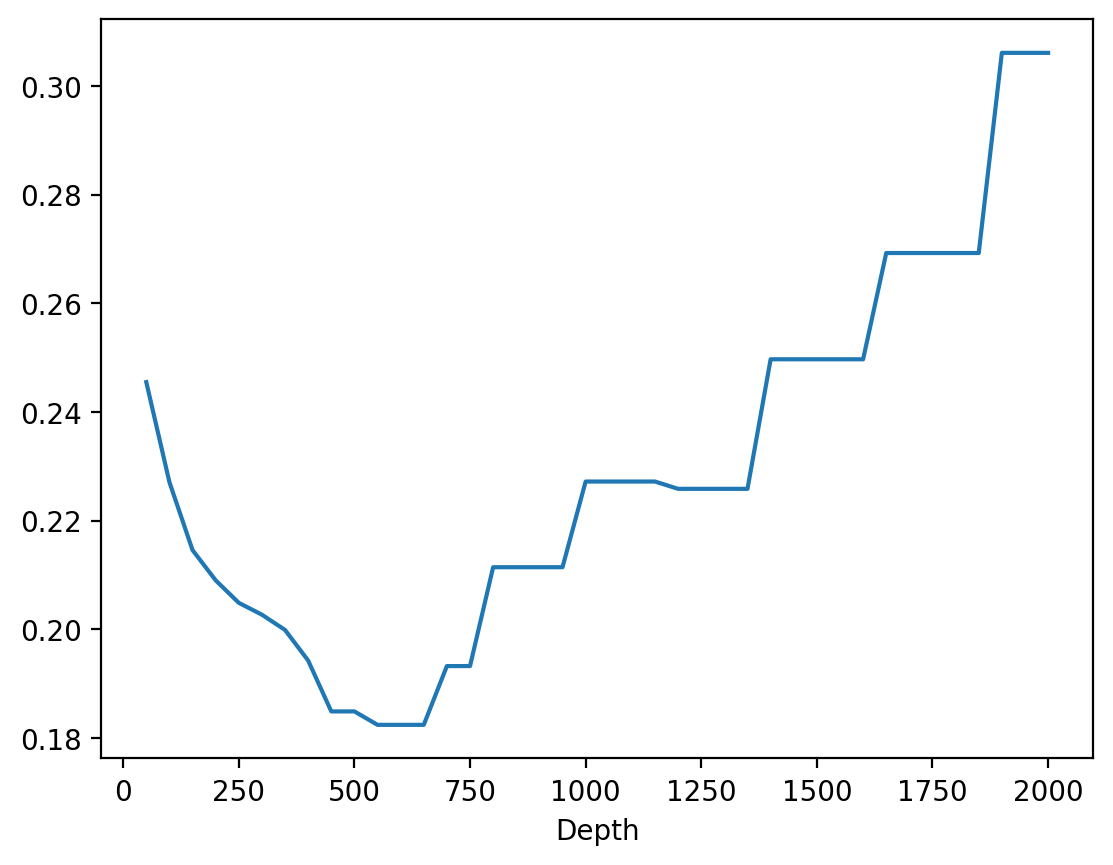

In [41]:
error_df['RMSE'].plot()

<AxesSubplot: xlabel='Depth'>

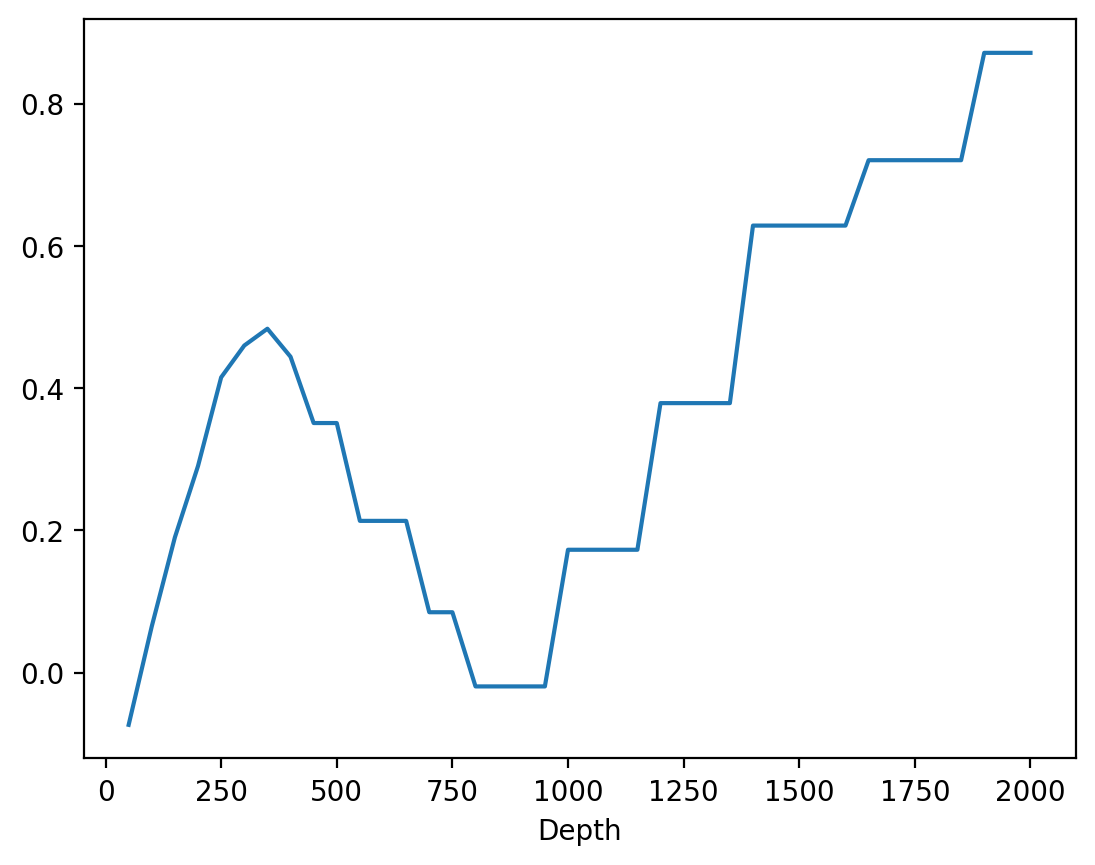

In [39]:
error_df['linear'].plot()

In [19]:
d = 500

st1 = slc.StericSL('EN4_22', 'EBB', 0, d, windows[0])
st2 = slc.StericSL('EN4_22', 'NWS', d, 4000, windows[1])

st = st1+st2
st = st.loc[b_df.index[0]:] - st.loc[b_df.index[0]]

nt = b_df.loc[:,'GIA':'Pressure'].sum(axis=1) + st.Steric
diff_df = b_df.Obs - nt
diff_df = diff_df - diff_df.mean()

<AxesSubplot: xlabel='time'>

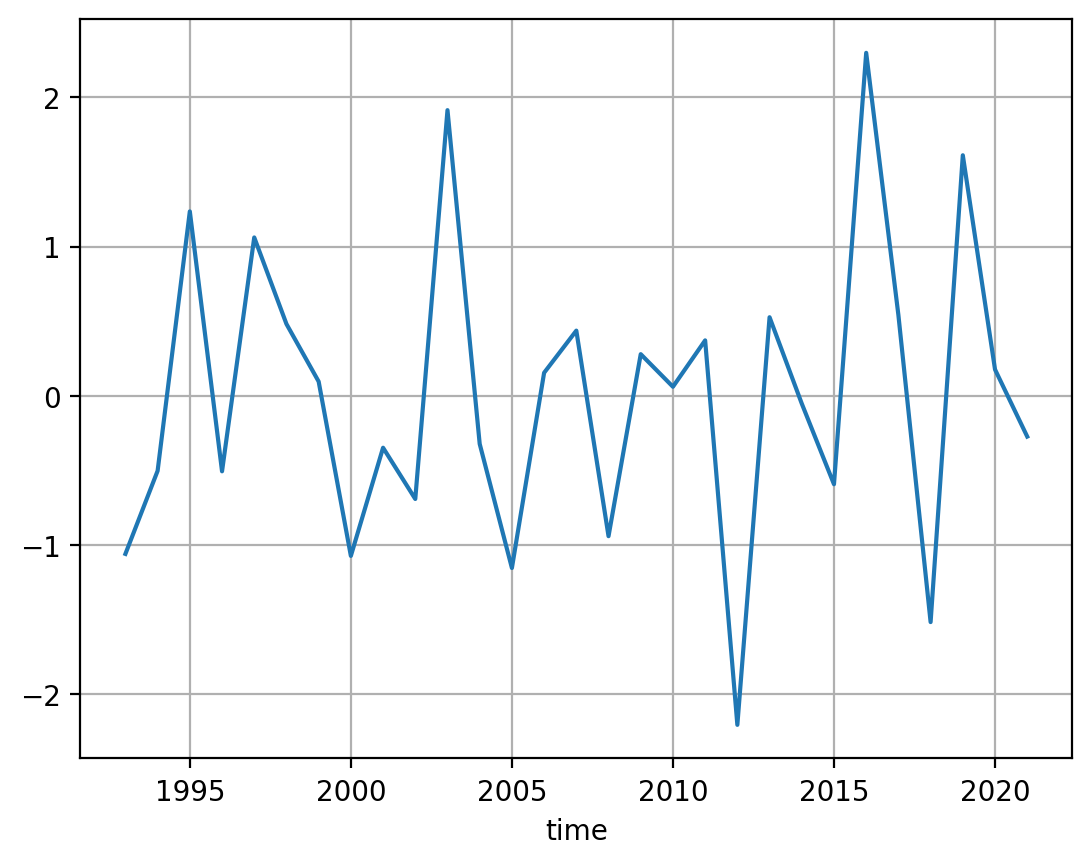

In [20]:
diff_df.plot(grid=True)

<AxesSubplot: xlabel='time'>

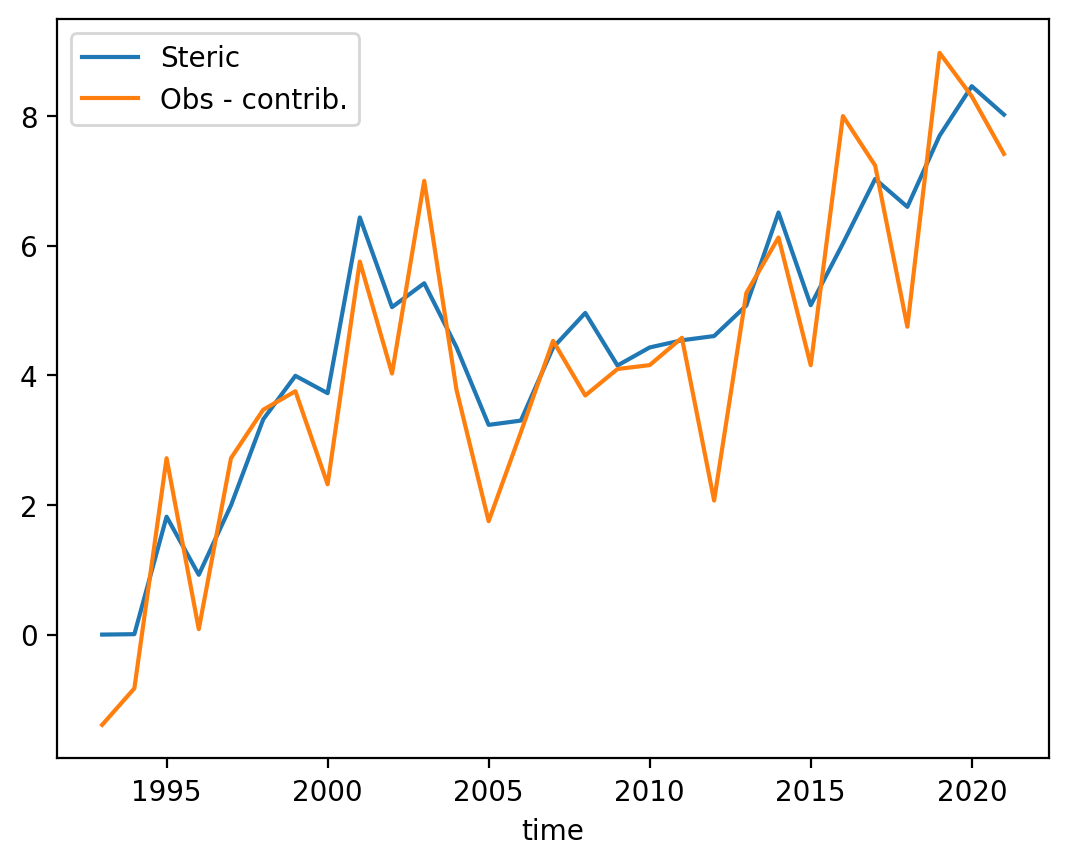

In [33]:
st.loc[b_df.index[0]:].plot()
(b_df.Obs-b_df.loc[:,'GIA':'Pressure'].sum(axis=1)).plot(c="tab:orange", label="Obs - contrib.", legend=True)


<AxesSubplot: xlabel='time'>

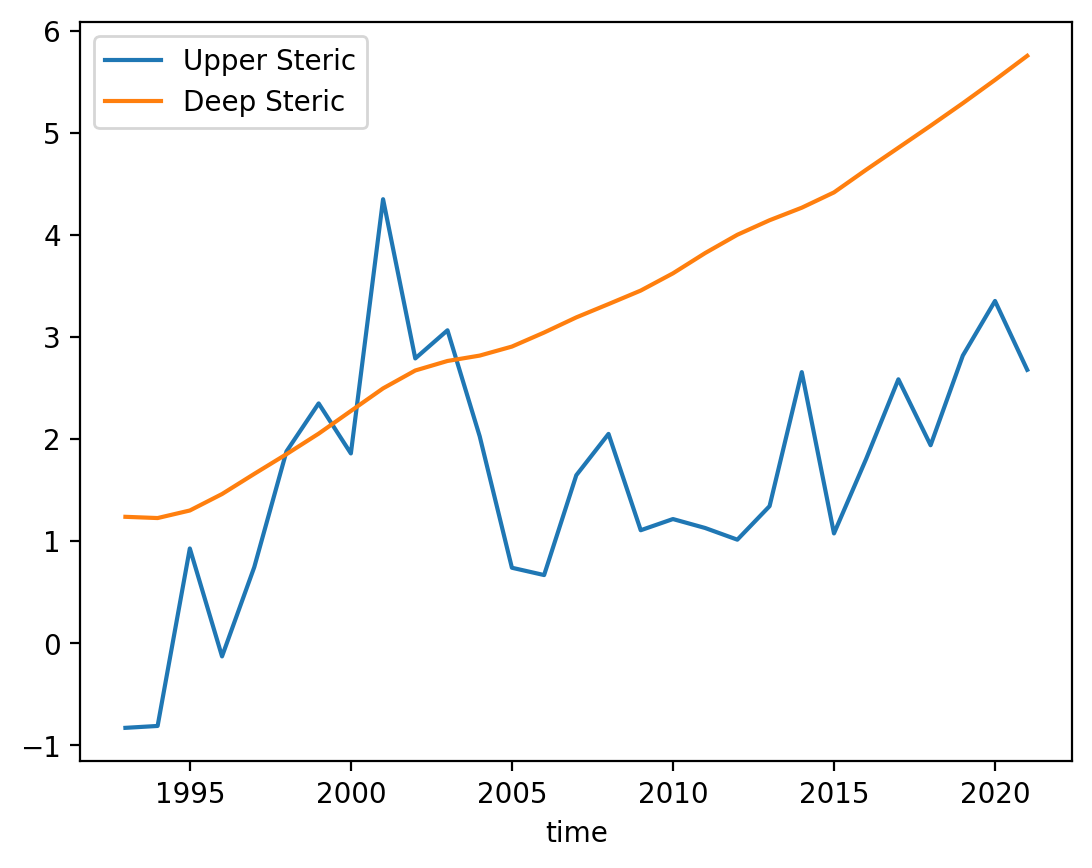

In [36]:
fig, ax = plt.subplots()

st1.rename(columns={'Steric':'Upper Steric'}).loc[b_df.index[0]:].plot(ax=ax)
st2.rename(columns={'Steric':'Deep Steric'}).loc[b_df.index[0]:].plot(ax=ax)

In [121]:
error_IAP_df.filter(like='RMSE').min()

RMSE_ENS_1     0.172557
RMSE_ENS_3     0.165359
RMSE_ENS_5     0.167504
RMSE_ENS_7     0.170371
RMSE_ENS_9     0.170669
RMSE_ENS_11    0.171532
RMSE_EBB_1     0.161939
RMSE_EBB_3     0.152715
RMSE_EBB_5     0.158530
RMSE_EBB_7     0.163849
RMSE_EBB_9     0.167867
RMSE_EBB_11    0.168301
RMSE_NWS_1     0.249478
RMSE_NWS_3     0.221599
RMSE_NWS_5     0.209402
RMSE_NWS_7     0.207235
RMSE_NWS_9     0.204872
RMSE_NWS_11    0.201500
dtype: float64

In [123]:
error_IAP_df.filter(like='AE').min()

AE_ENS_1     1.171356
AE_ENS_3     1.130133
AE_ENS_5     1.140439
AE_ENS_7     1.166539
AE_ENS_9     1.168990
AE_ENS_11    1.177278
AE_EBB_1     1.035186
AE_EBB_3     1.015667
AE_EBB_5     1.083718
AE_EBB_7     1.135117
AE_EBB_9     1.173698
AE_EBB_11    1.178892
AE_NWS_1     1.747034
AE_NWS_3     1.506065
AE_NWS_5     1.402831
AE_NWS_7     1.400262
AE_NWS_9     1.376667
AE_NWS_11    1.354868
dtype: float64

In [125]:
error_IAP_df.filter(like='linear')

linear_ENS_1    -0.345933
linear_ENS_3    -0.335152
linear_ENS_5    -0.333546
linear_ENS_7    -0.315376
linear_ENS_9    -0.317905
linear_ENS_11   -0.324469
linear_EBB_1    -0.559018
linear_EBB_3    -0.512764
linear_EBB_5    -0.513545
linear_EBB_7    -0.519772
linear_EBB_9    -0.524674
linear_EBB_11   -0.523103
linear_NWS_1     0.062478
linear_NWS_3     0.049681
linear_NWS_5     0.043073
linear_NWS_7     0.047914
linear_NWS_9     0.054937
linear_NWS_11    0.058930
dtype: float64

In [128]:
error_IAP_df['AE_EBB_3'] #.plot()

Depth
100     1.687117
200     1.425087
300     1.214005
400     1.071755
500     1.037851
600     1.053814
700     1.052458
800     1.039080
900     1.023273
1000    1.024208
1100    1.015667
1200    1.016563
1300    1.018877
1400    1.026210
1500    1.046463
1600    1.065588
1700    1.115478
1800    1.199618
1900    1.199618
2000    1.336895
Name: AE_EBB_3, dtype: float64

In [211]:
error_IAP_df['linear_ENS_3']

Depth
100     0.690036
200     0.540149
300     0.445625
400     0.359465
500     0.189113
600     0.112920
700     0.059244
800     0.019183
900     0.000461
1000    0.014398
1100    0.036510
1200    0.022711
1300   -0.000912
1400   -0.038548
1500   -0.075219
1600   -0.124190
1700   -0.175229
1800   -0.248050
1900   -0.248050
2000   -0.335152
Name: linear_ENS_3, dtype: float64